In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split

In [3]:
import pymc3 as pm
from scipy.optimize import fmin_powell
from scipy import integrate

import theano as thno
import theano.tensor as tt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [30]:
def plot_trace(trace):
    ax = pm.traceplot(trace, figsize=(12, len(trace.varnames)*1.5),
                      lines={k: v['mean'] for k, v in pm.df_summary(trace).iterrows()})
    
    for i, mn in enumerate(pm.df_summary(trace)['mean']):
        ax[i, 0].annotate('{:0.2f}'.format(mn), xy = (mn, 0), xycoords = 'data',
                          xytext = (5, 10), textcoords = 'offset points', rotation = 90,
                          va = 'bottom', fontsize = 'large', color = 'red')
        

# Load in Data

We are using the [Pima Indians diabetes dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database). The objective is a binary classification model that predicts whether or not an individual has diabetes based on several indicators.

In [4]:
data = pd.read_csv('data/diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
features = data.drop(columns='Outcome')
labels = data.Outcome

X, X_test, y, y_test = train_test_split(features, labels, test_size=200)

In [19]:
formula = [' %s + ' % variable for variable in X.columns]
formula.insert(0, 'y ~ ')
formula = ' '.join(''.join(formula).split(' ')[:-2])
formula

'y ~  Pregnancies +  Glucose +  BloodPressure +  SkinThickness +  Insulin +  BMI +  DiabetesPedigreeFunction +  Age'

# Logistic Model

In [28]:
X_with_labels = X.copy()
X_with_labels['y'] = y

In [23]:
with pm.Model() as logistic_model:
    # Create the model using the formula
    pm.glm.GLM.from_formula(formula, data = X_with_labels, family = pm.glm.families.Binomial())
    
    sampler = pm.NUTS()
    
    # Sample from the posterior using NUTS
    trace_log = pm.sample(draws=5000, step = sampler, chains=2, tune=1000)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Age, DiabetesPedigreeFunction, BMI, Insulin, SkinThickness, BloodPressure, Glucose, Pregnancies, Intercept]


# Interpret Results

## Traceplot of Sampled Variables

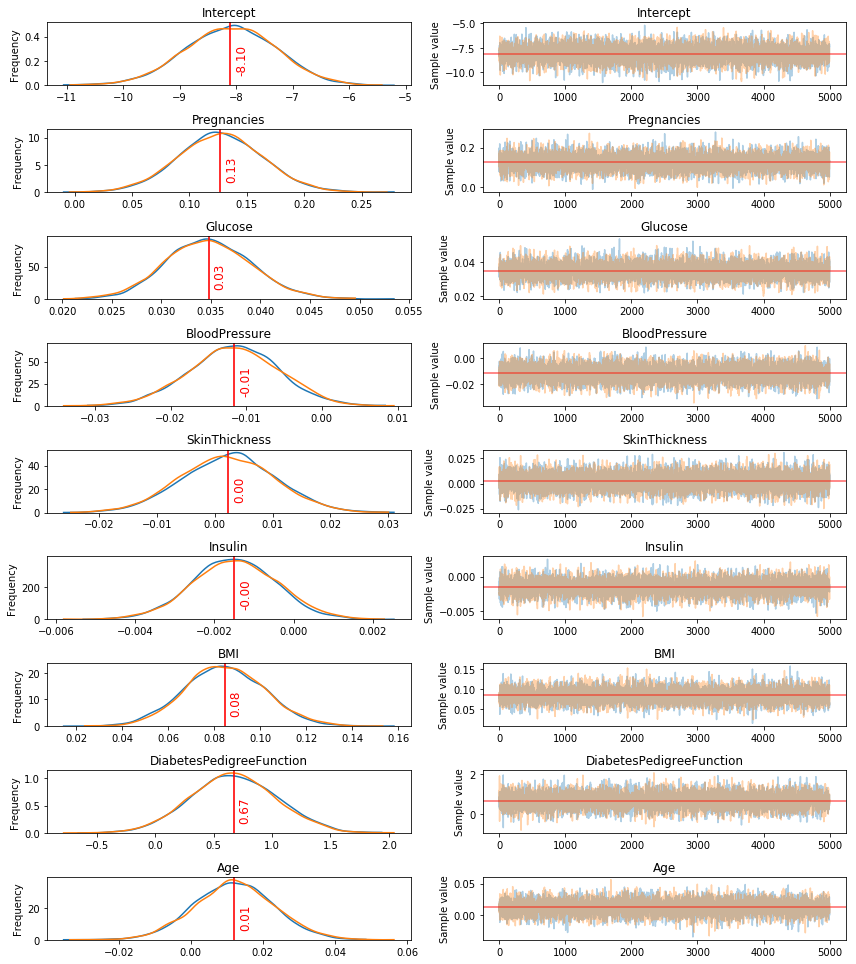

In [31]:
plot_trace(trace_log)

In [67]:
def evaluate_trace(trace, data):
    means_dict = {}
    std_dict = {}
    
    for var in trace.varnames:
        means_dict[var] = np.mean(trace[var])
        std_dict[var] = np.std(trace[var])
    
    model = 'y = %0.4f + ' % np.mean(means_dict['Intercept'])
    
    for var in data.columns:
        model += '%0.4f * %s + ' % (means_dict[var], var)
    
    model = ' '.join(model.split(' ')[:-2])
    print('Final Equation: \n{}'.format(model))
    
    return means_dict, std_dict

In [68]:
means_dict, std_dict = evaluate_trace(trace_log, X)

Final Equation: 
y = -8.1007 + 0.1266 * Pregnancies + 0.0348 * Glucose + -0.0116 * BloodPressure + 0.0023 * SkinThickness + -0.0015 * Insulin + 0.0845 * BMI + 0.6710 * DiabetesPedigreeFunction + 0.0120 * Age


In [71]:
data = X_test.copy()
data['Intercept'] = 1

In [75]:
data = data[list(means_dict.keys())]

In [76]:
data.head()

,Intercept,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
544,1,1,88,78,29,76,32.0,0.365,29
180,1,6,87,80,0,0,23.2,0.084,32
547,1,4,131,68,21,166,33.1,0.160,28
745,1,12,100,84,33,105,30.0,0.488,46
719,1,5,97,76,27,0,35.6,0.378,52


In [82]:
list(means_dict.values())

[-8.100672843732557,
 0.1265708333886771,
 0.03476444609832606,
 -0.011617387483528195,
 0.0022781174936516236,
 -0.0015066837410047578,
 0.08448877100713494,
 0.6710247847581089,
 0.011971448656349892]

In [83]:
np.dot(data.loc[544], np.array(list(means_dict.values())))

-2.573692804707675

In [86]:
def make_predictions(means_dict, data):
    predictions = []
    mean_array = np.array(list(means_dict.values()))
    
    data['Intercept'] = 1
    data = data[list(means_dict.keys())]
    
    for _, row in data.iterrows():
        logit = np.dot(row, mean_array)
        probability = 1 / (1 + np.exp(-logit))
        predictions.append(probability)
        
    return predictions

In [87]:
probs = make_predictions(means_dict, X_test)

In [88]:
probs

[0.07085081754236397,
 0.05486043937761242,
 0.31144861035806304,
 0.3205048180109327,
 0.2624803064031676,
 0.7860815386912199,
 0.6689987594535948,
 0.9168003408082541,
 0.38955891325562625,
 0.81630156708335,
 0.12000535962078314,
 0.7521248742534092,
 0.1197234775727791,
 0.9181170232357113,
 0.8925789334618294,
 0.022175975385034324,
 0.1327553113507279,
 0.5716554425484526,
 0.208716657110497,
 0.7988643483253911,
 0.2073126438811212,
 0.0541823520619593,
 0.12347536460067392,
 0.40965225637224706,
 0.12436401110986886,
 0.8123429510281781,
 0.6657701244273867,
 0.4801643149203611,
 0.0666893400342976,
 0.28306762249132916,
 0.43839655894227886,
 0.19956033993835537,
 0.2746106329551382,
 0.0960383329817054,
 0.4935341679273565,
 0.6244192597465282,
 0.13447493072172775,
 0.3372338716615062,
 0.3209817860224308,
 0.23261801400960067,
 0.23243005459487934,
 0.1445438276248088,
 0.39939616591720106,
 0.8128195556934276,
 0.404028761883784,
 0.3172715759605819,
 0.0171107318131885,


In [92]:
np.mean((np.array(probs) > 0.5) == y_test)

0.775

In [93]:
np.mean(0 == y_test)

0.625

In [94]:
np.mean(1 == y_test)

0.375